In [4]:
!pip install rasterio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.4 MB/s eta 0:00:00


In [33]:
# Bibliotecas
import ee
import numpy as np
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image

In [2]:
# Autenticação Earth Engine
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=l9WhJINdTGI4Oml6UQ2XthTnAz6uxTEE0N89DvLtwYs&tc=S4ej7uweleQtZ0TTisdQij75MtkeusePqYdV9ci1x3M&cc=OVMJ6rUFydzv_BUjMbFvaMFTIrxMnIXfOFDLpRSJ4as

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXm8Y1VE9phTQqNfKbFjcinlzCKOYkkHdvYiRBd5u0XqdjmAKcLSeAY

Successfully saved authorization token.


In [ ]:
# Função de leitura da área de interesse
def read_geometry(geom):
  gdf = gpd.read_file(geom)
  gdf_json = gdf.to_json()
  gdf_json = json.loads(gdf_json)
  gdf_coord = gdf_json['features']
  aoi = ee.FeatureCollection(gdf_coord)
  return aoi

In [19]:
# Função para selecionar coleção
def collection_select(date_start, date_end, cloud, coord):

  landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
    .filterDate(date_start,date_end)\
    .filter(ee.Filter.lt('CLOUD_COVER',cloud))\
    .filterBounds(coord)\
    .map(lambda image: image.clip(coord).unmask())

  return landsat

In [8]:
# Função para cálculo do ndvi
def ndvi_lst(img):
  return img.normalizedDifference(['SR_B5', 'SR_B4']).rename('index')

In [12]:
# Converter geojson para EE.geometry
def listPoints(Geometry):
    pointList = []
    try:
        for part in Geometry:
            x, y = part.exterior.coords.xy
            pointList.append(list(zip(x,y)))
    except:
        try:
            x,y = Geometry.exterior.coords.xy
            pointList.append(list(zip(x,y)))
        except:
            pointList.append(Geometry)
    return pointList

def to_eeGeometry(geom):

  geo = gpd.read_file(geom)
  l = geo.geometry.apply(lambda x: listPoints(x)).values.tolist()
  t = [list(l[0][0][i]) for i in range(len(l[0][0]))]
  geom = ee.Geometry.Polygon([t])
  feature = ee.Feature(geom, {})

  roi = feature.geometry()
  return roi

In [64]:
# Função para download de múltiplas datas em um único arquivo
date_ranges = [
    ("2019-09-01", "2019-09-30"),
    ("2020-09-01", "2020-09-30"),
    ("2021-09-01", "2021-09-30"),
    ("2022-09-01", "2022-09-30")
]
roi = to_eeGeometry('/content/pnb_corte.geojson')
def download_images(date_ranges, cloud, coord, scale, filename, index_fun=ndvi_lst):
    # Crie uma lista para armazenar as imagens individuais
    images = []

    for date_range in date_ranges:
        date_start, date_end = date_range
        col = collection_select(date_start, date_end, cloud, coord)
        v_index = col.map(index_fun)
        combined_image = v_index.mosaic()
        images.append(combined_image)

    # Combine as imagens individuais em uma única imagem multibanda
    combined_multiband_image = ee.ImageCollection(images).toBands()

    # Exporte a imagem multibanda para um único arquivo
    geemap.ee_export_image(combined_multiband_image, filename=filename, scale=scale, region=roi)

In [65]:
# Baixando imagens
area = read_geometry('/content/pnb_corte.geojson')
download_images(date_ranges, 1, area, 30,'/content/ndvi_cubo.tif')

Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_cubo.tif


In [66]:
# Lendo resultado
src = rio.open('/content/ndvi_cubo.tif')
img = reshape_as_image(src.read())

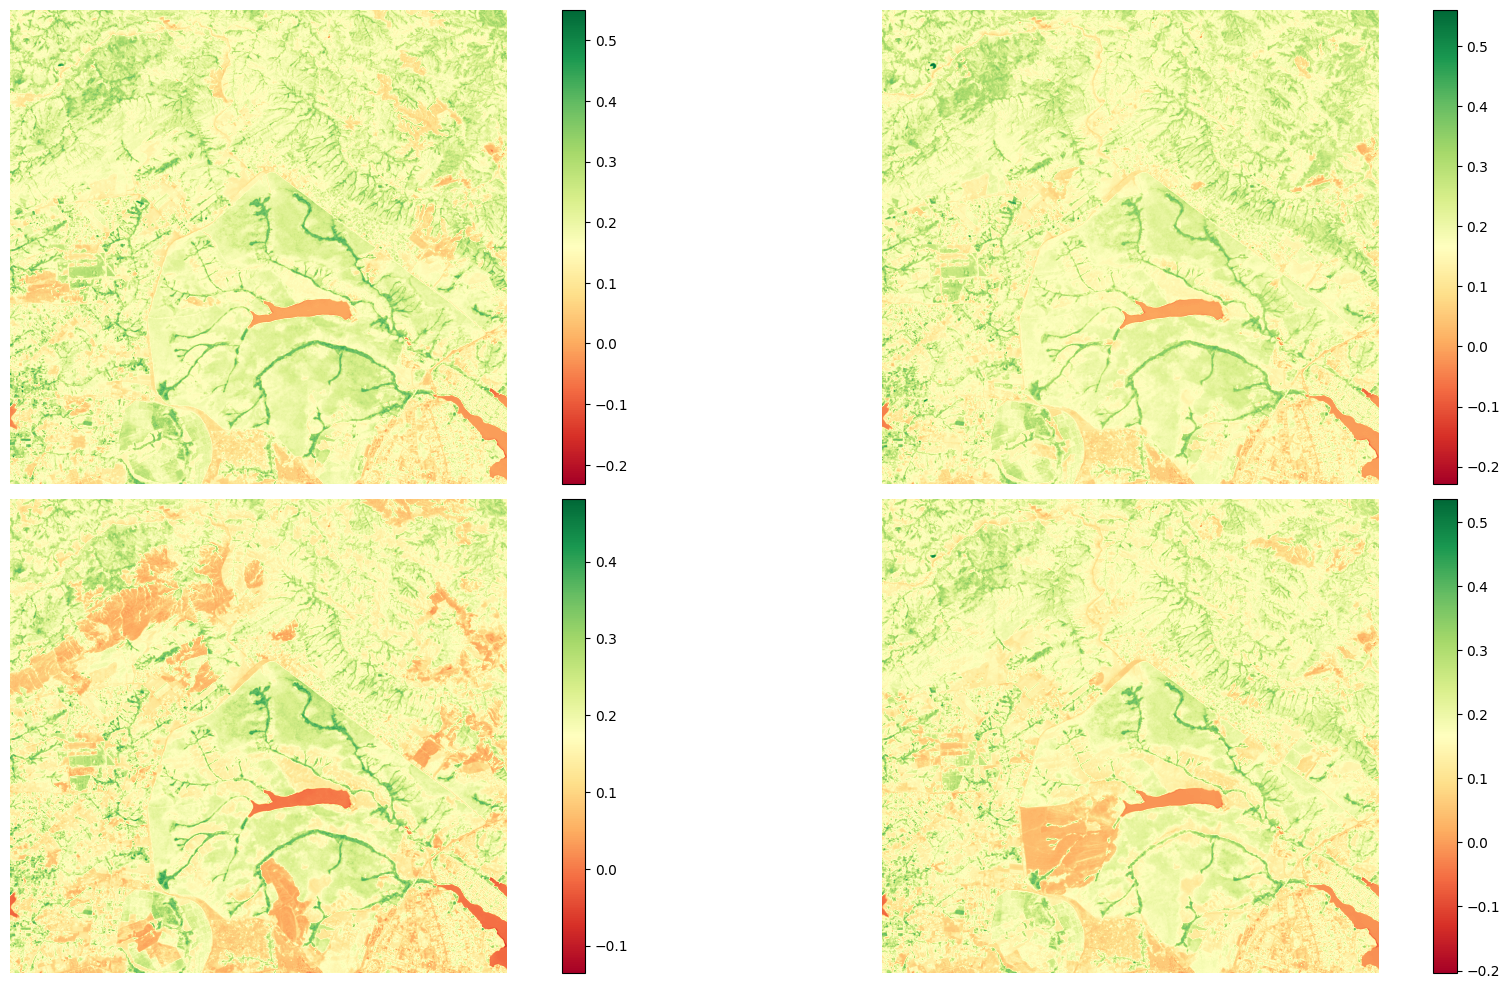

In [81]:
#Plotando as imagens separadamente
fig,axes = plt.subplots(2,2,figsize=(20,10),sharex='all', sharey='all')

axes = axes.ravel()
for i in range(img.shape[2]):
    im = axes[i].imshow(img[..., i], cmap='RdYlGn')
    axes[i].axis('off')
    fig.colorbar(im, ax=axes[i])
plt.tight_layout()
plt.show()